# Load the training data

In [1]:
import scipy.io as sio
rawtraining = sio.loadmat('givenData/TrainingSamplesDCT_8.mat')

# Estimate the prior probabilities from training data
By assuming the ratio of training samples for cheetah to total training samples for background and cheetah represents the prior probability of cheetah, $P(\text{cheetah})$. The prior probability of background is then $P(\text{background})=1-P(\text{cheetah})$.

In [2]:
numtrainFG, numtrainBG = rawtraining['TrainsampleDCT_FG'].shape[0], rawtraining['TrainsampleDCT_BG'].shape[0]
priorFG = numtrainFG/(numtrainBG+numtrainFG)
priorBG = 1-priorFG

print('Number of Cheetah Training Samples:\t{0}\nNumber of Background Training Samples:\t{1}'.format(numtrainFG,numtrainBG))
print('P(cheetah)=\t{0:4.3f}\nP(background)=\t{1:4.3f}'.format(priorFG,priorBG))

Number of Cheetah Training Samples:	250
Number of Background Training Samples:	1053
P(cheetah)=	0.192
P(background)=	0.808


# Create a histogram of DCT values 
This will be used to determine the class conditional propabilities $p(\text{dct}\ |\ \text{cheetah})$ and $p(\text{dct}\ |\ \text{background})$ which are needed to calculate the Bayesian classifier $p(\text{cheetah}\ |\ \text{dct})>p(\text{background}\ |\ \text{dct})$ which implies $p(\text{dct}\ |\ \text{cheetah})p(\text{cheetah})>p(\text{dct}\ |\ \text{background})p(\text{background})$.

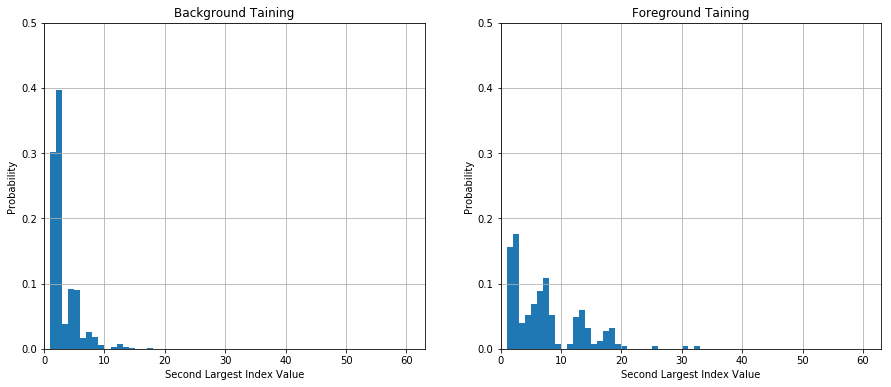

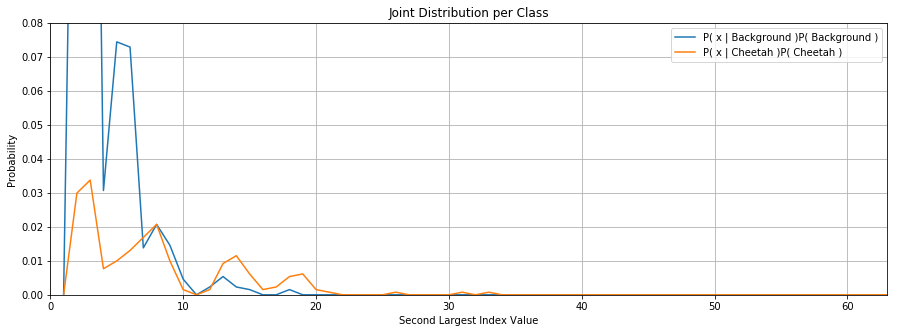

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import describe

numbins = 64
dctlargest = 2

TrainsampleDCT_BG = rawtraining['TrainsampleDCT_BG']
TrainsampleDCT_FG = rawtraining['TrainsampleDCT_FG']

trainBGbinidx = np.zeros(numtrainBG)
for nn in range(0,numtrainBG):
    data = TrainsampleDCT_BG[nn]
    absdata = np.absolute(data)  
    trainBGbinidx[nn] = np.argsort(absdata)[-dctlargest] # get second largest

bincntsBG = np.histogram(trainBGbinidx, bins=list(range(0,numbins)))
bincntsBG = bincntsBG[0]
totalcntsBG = np.sum(bincntsBG)
probDCTgBG = bincntsBG/totalcntsBG

plt.figure(0, figsize=(15,6))
plt.subplot(1,2,1)
x1 = plt.hist(trainBGbinidx, bins=list(range(0,numbins)), normed=1)
plt.ylim([0,0.5])
plt.xlim([0,63])
plt.title(r'Background Taining')
plt.xlabel('Second Largest Index Value')
plt.ylabel('Probability')
plt.grid()

trainFGbinidx = np.zeros(numtrainFG)
for nn in range(0,numtrainFG):
    data = TrainsampleDCT_FG[nn]
    absdata = np.absolute(data)  
    trainFGbinidx[nn] = np.argsort(absdata)[-dctlargest] # get second largest

bincntsFG = np.histogram(trainFGbinidx, bins=list(range(0,numbins)))
bincntsFG = bincntsFG[0]
totalcntsFG = np.sum(bincntsFG)
probDCTgFG = bincntsFG/totalcntsFG

plt.subplot(1,2,2)
x2 = plt.hist(trainFGbinidx, bins=list(range(0,numbins)), normed=1)
plt.ylim([0,0.5])
plt.xlim([0,63])
plt.title(r'Foreground Taining')
plt.xlabel('Second Largest Index Value')
plt.ylabel('Probability')
plt.grid()
plt.savefig('trainingHistograms', dpi=600, bbox_inches='tight')
plt.show()

plt.figure(1, figsize=(15,5))
plt.plot(x1[1][1:], probDCTgBG*priorBG)
plt.plot(x2[1][1:], probDCTgFG*priorFG)
plt.title('Joint Distribution per Class')
plt.xlabel('Second Largest Index Value')
plt.ylabel('Probability')
plt.ylim([0,0.08])
plt.xlim([0,63])
plt.grid()
plt.legend(['P( x | Background )P( Background )', 'P( x | Cheetah )P( Cheetah )'])
plt.savefig('trainingDensities', dpi=600, bbox_inches='tight')
plt.show()

# Read in the grayscale image of a cheetah
Also convert from an array of integers between 0 and 255 to an array of doubles between 0 and 1 to match the training data format

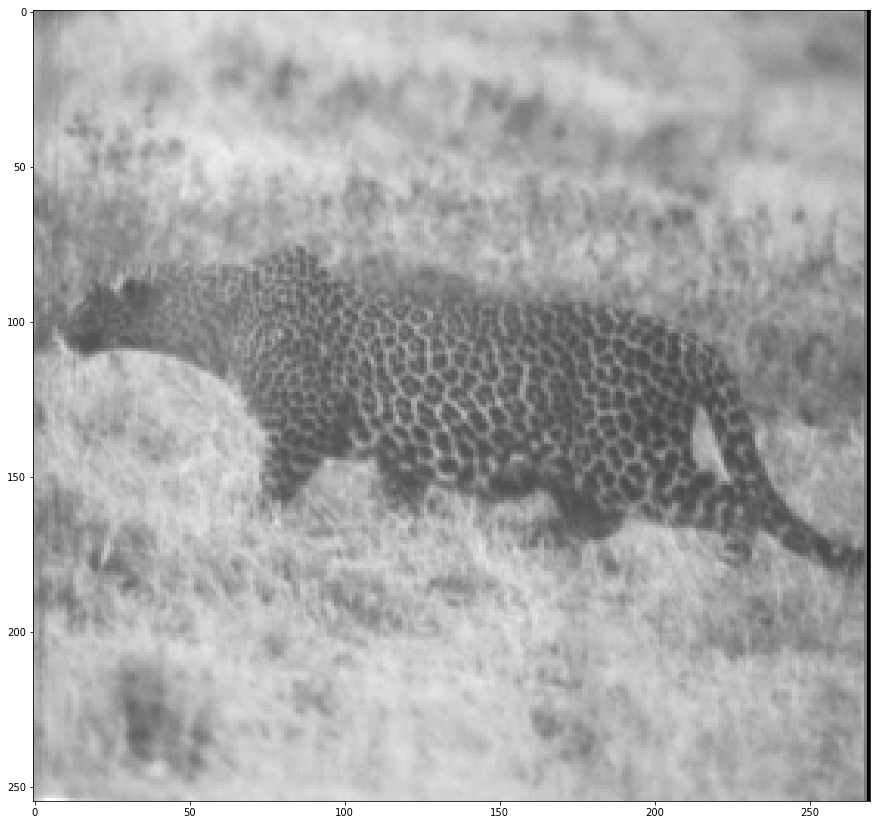

In [4]:
from scipy.misc import imread

rawimage = imread('givenData/cheetah.bmp', 'L')
plt.figure(figsize=(15,15))
plt.imshow(rawimage, cmap='gray')
plt.show()

doubleimage = rawimage.astype(float)/255 # convert from intergers 0->255 to floats 0->1

# Function to determine the 2-D discrete time transform from 1-D transforms
We need this because scipy does not have a direct implementation of the 2D transform

In [5]:
def dct2(img):
    """ Get 2D Cosine Transform of Image
    """
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

# Implement the classifier 
Go through the cheetah image in blocks of 8x8 pixels with a stride of 1 pixel, take the 2-D DCT of each of these blocks, take the magnitude, vectorize using the zigzag pattern given and choose the index of the second largest element. This will be the feature we use to determine cheetah vs background going forward.

In [6]:
from scipy.fftpack import dct

blksizecol = 8    # the number of horizontal pixels per block
blksizerow = 8    # the number of vertical pixels per block
dctlargest = 2    # choose this variables value largest dct from array
priorFG = 0.16 #0.16  # lets you play with the prior if you would like
priorBG = 1-priorFG

numrow, numcol = doubleimage.shape
cheetahmask = np.zeros((numrow,numcol))
dctflatordered = np.zeros(blksizerow*blksizecol)
for mm in range(numrow - blksizerow):
    for nn in range(numcol - blksizecol):
        block = doubleimage[mm:mm+blksizerow, nn:nn+blksizecol]
        blockdct = np.absolute(dct2(block))        
        blockdctflat = np.ndarray.flatten(blockdct)
        
        # this ordering keeps similar frequency values in contiguous array elements
        zigzagpattern = np.array([[ 0, 1, 5, 6,14,15,27,28],
                                  [ 2, 4, 7,13,16,26,29,42],
                                  [ 3, 8,12,17,25,30,41,43],
                                  [ 9,11,18,24,31,40,44,53],
                                  [10,19,23,32,39,45,52,54],
                                  [20,22,33,38,46,51,55,60],
                                  [21,34,37,47,50,56,59,61],
                                  [35,36,48,49,57,58,62,63]])
        zigzagflat = np.ndarray.flatten(zigzagpattern)
        
        # This loop does the reordering
        for ww in range(0,blksizecol*blksizerow):
            dctflatordered[zigzagflat[ww]] = blockdctflat[ww]
        
        binidx = np.argsort(dctflatordered)[-dctlargest] # get second largest
        
        # cheetahmask values should be either 0 for black pixels and 255 for white pixels
        FGorBGbigger = (probDCTgFG[binidx]*priorFG) > (probDCTgBG[binidx]*priorBG)
        cheetahmask[mm,nn] = np.array(FGorBGbigger, dtype=int)*255

# Calculate the probability of error
This is done by comparing the generated mask to the given true mask pixel by pixel.

In [7]:
truemask = imread('givenData/cheetah_mask.bmp', 'L')

rowpix, colpix = truemask.shape
totalpix = rowpix*colpix
errors = truemask != cheetahmask
numerrors = np.sum(errors)
perror = numerrors/totalpix

print('P(error) = {0:4.2%}'.format(perror))

P(error) = 16.84%


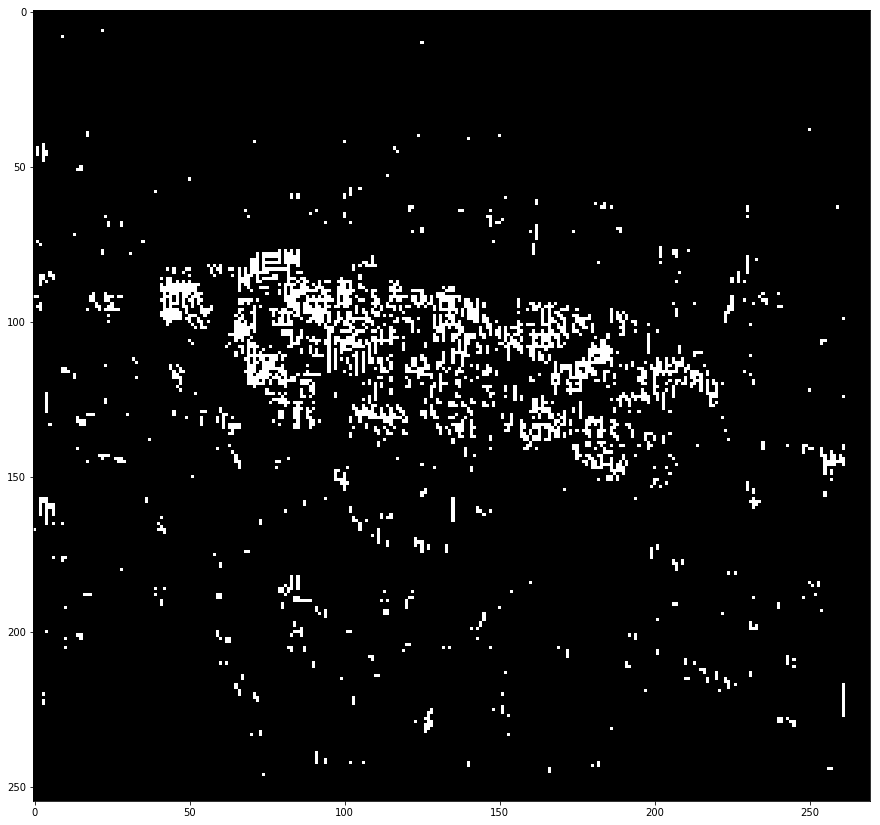

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(cheetahmask, cmap='gray')
plt.savefig('cheetahmask', dpi=600, bbox_inches='tight')
plt.show()

The above is the generated mask of the cheetah with white pixels denoting what the algorithm classified as cheetah and black pixels denoting background. The error was computed to be 16.8%. 